# Neutron tagging lab
## Data analysis code and lab notebook

### Introduction
* Intro text here

### Let's take some data!
* instructions here

### How to run this analysis
* explain dependencies, libraries, plotting, interaction
* instructions here

For data storage and analysis, we rely on the *numpy* and *scipy* packages. And to plot things, we use the *matplotlib* library. We need to import both before the first use and initialize the interactive plots inside the notebook:

In [1]:
import numpy as np
import scipy
import matplotlib
# choose a backend for web applications; remove for stand-alone applications:
matplotlib.use('Agg')
import matplotlib.pyplot as plt
# enable interactive notebook plots (
# alternative: use 'inline' instead of 'notebook' for static images)
%matplotlib notebook

### Plotting the time-of-flight data

<IPython.core.display.Javascript object>


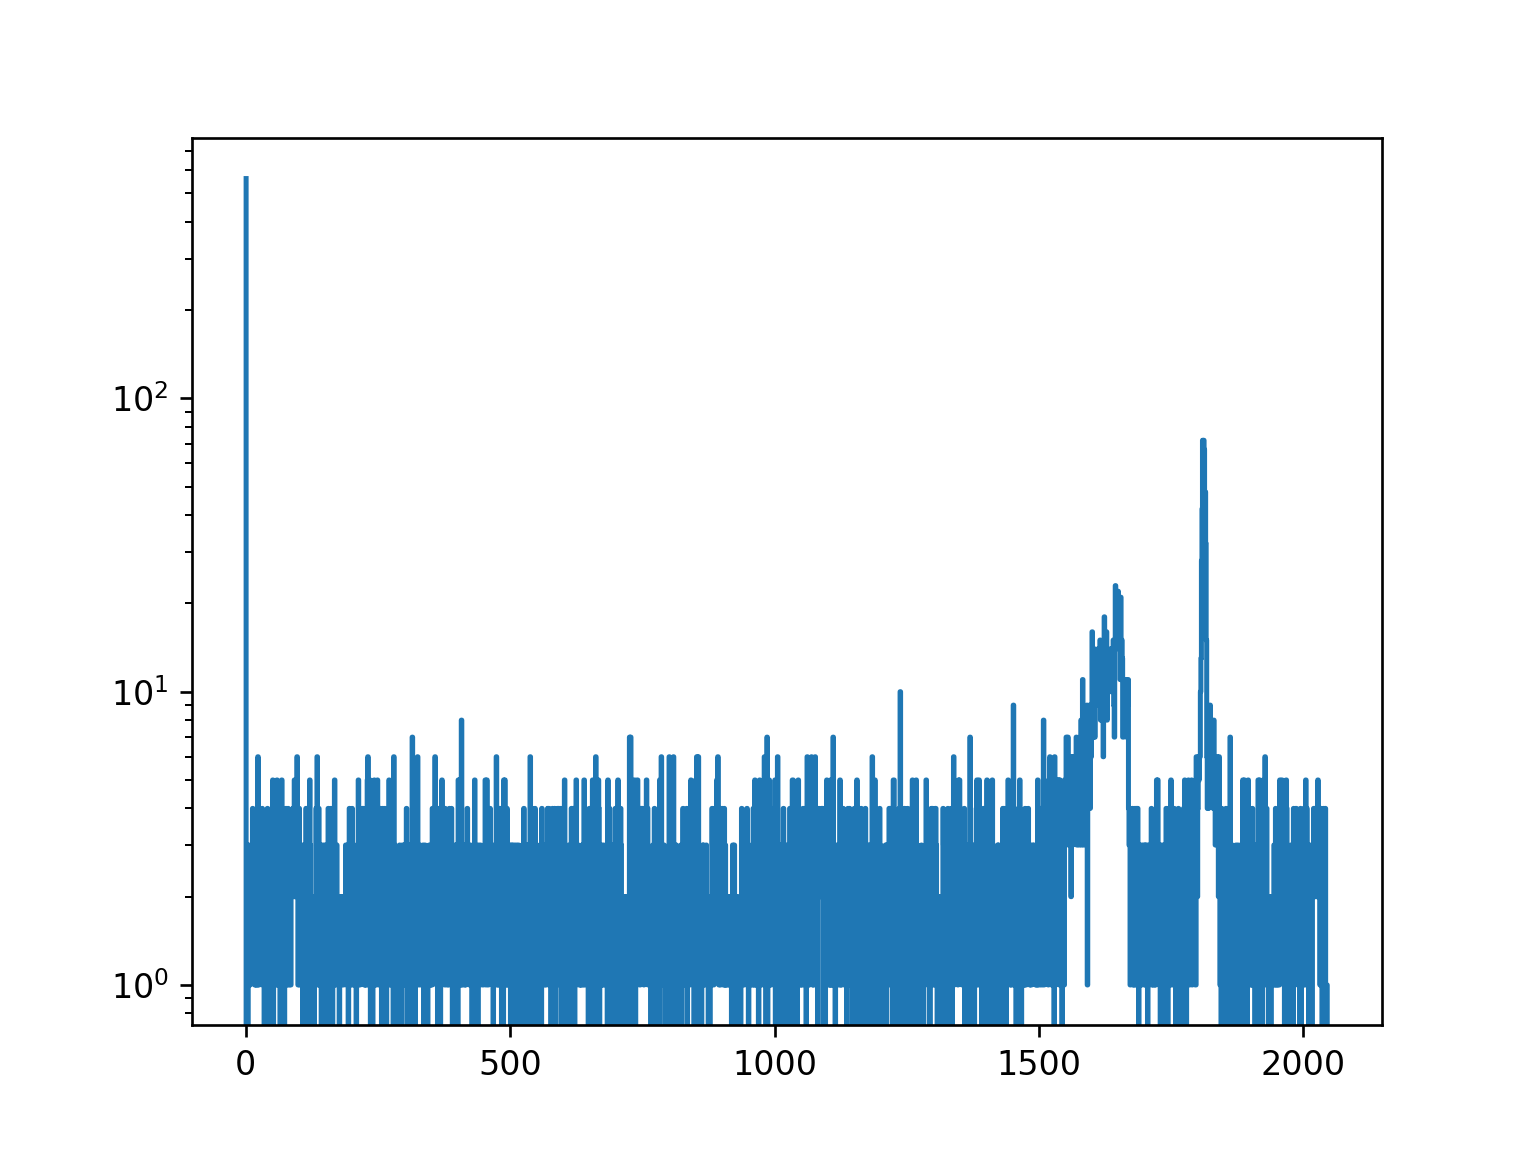

In [2]:
import histhelpers
from histhelpers import getBinCenters

tof = histhelpers.import_hist_from_csv('hc1_5_0.csv')

fig, axes = plt.subplots() # makes new plot
plt.yscale('log')
axes.plot(getBinCenters(tof.bins), tof.data, linestyle="steps")

Let's fit the data to identify the gamma flash peak position:

In [3]:
import fithelpers
gfits = fithelpers.fit_all_gaussians(getBinCenters(tof.bins), tof.data, loglevel="WARNING")

<IPython.core.display.Javascript object>


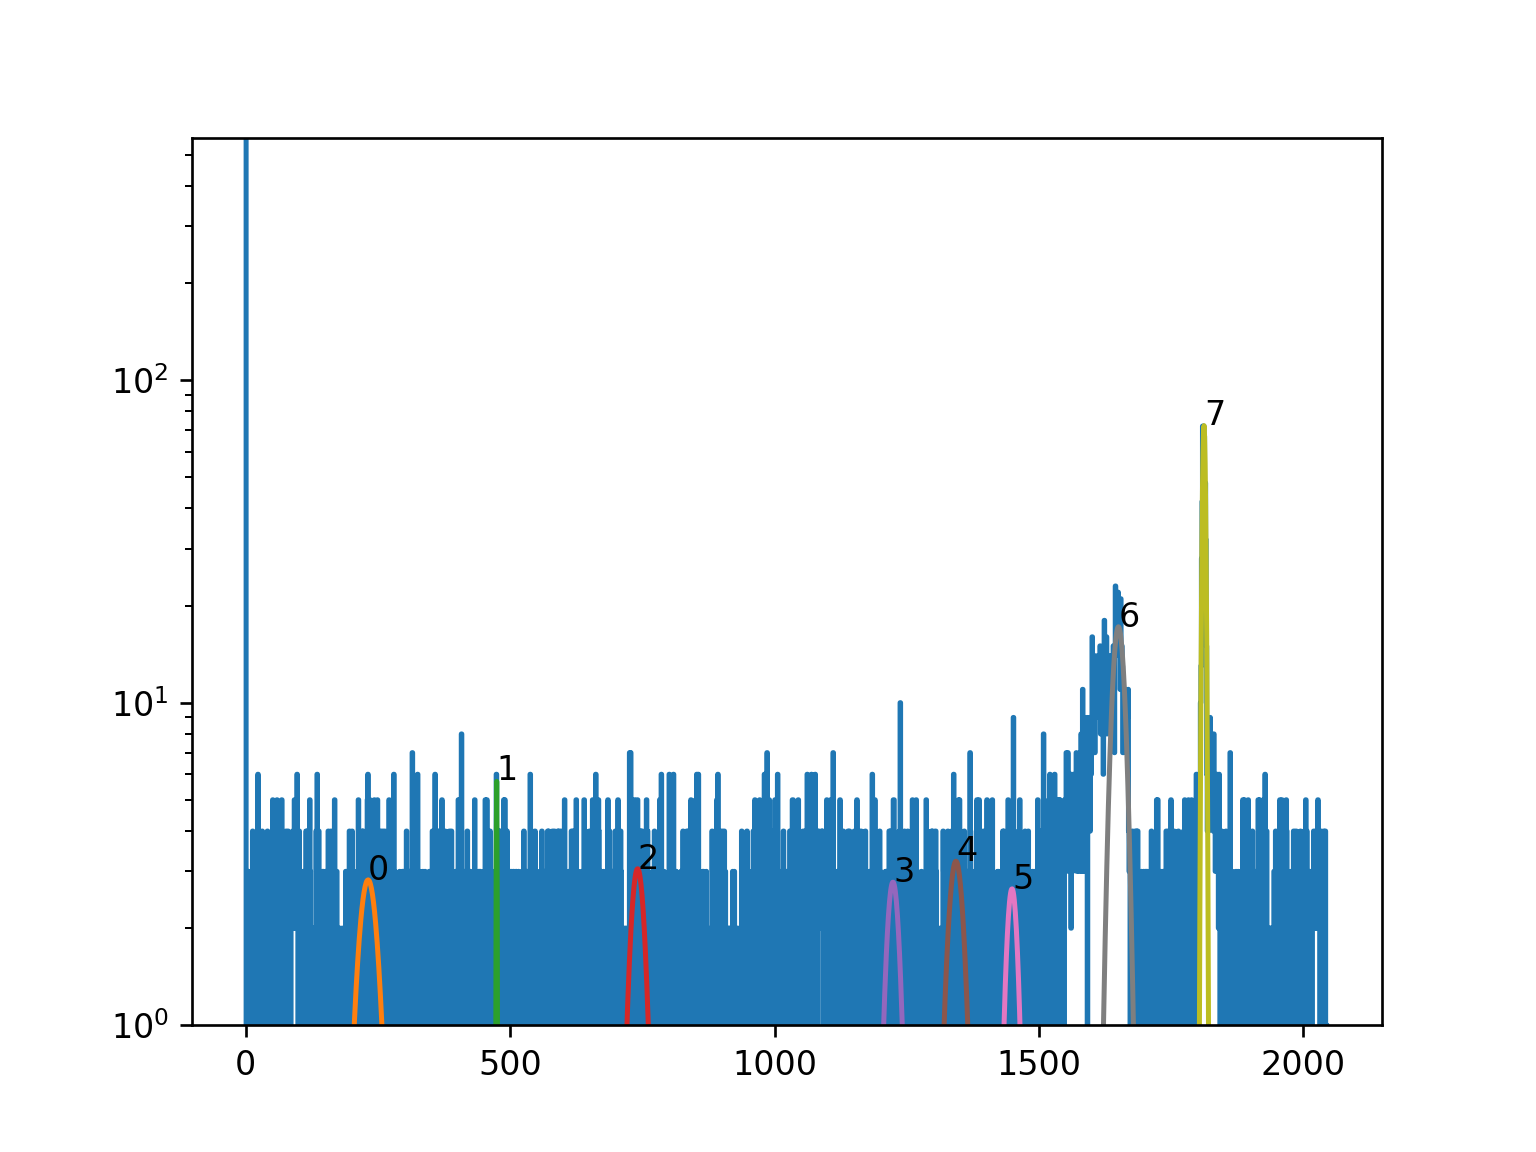

Fitted Gaussian #0: A: 2.8228, mu: 231.2036, sigma: 18.1766
Fitted Gaussian #1: A: 5.7551, mu: 474.3855, sigma: 0.8488
Fitted Gaussian #2: A: 3.0561, mu: 741.071, sigma: 13.5275
Fitted Gaussian #3: A: 2.7783, mu: 1224.0271, sigma: 12.3249
Fitted Gaussian #4: A: 3.2244, mu: 1343.1488, sigma: 14.6476
Fitted Gaussian #5: A: 2.6485, mu: 1449.2185, sigma: 10.8343
Fitted Gaussian #6: A: 17.1944, mu: 1650.5665, sigma: 11.8869
Fitted Gaussian #7: A: 72.3599, mu: 1812.331, sigma: 2.951


In [4]:
fig, axes = plt.subplots()

# plot data
plt.yscale('log')
plt.ylim(ymin=1, ymax=max(tof.data))
axes.plot(getBinCenters(tof.bins), tof.data, label="TOF data", ls="steps") # ls == linestyle

for idx, g in enumerate(gfits):
    ## print a line with the fit result
    print("Fitted Gaussian #{}: {}".format(idx, g.as_string()))
    ## plot this gaussian fit too
    axes.plot(getBinCenters(tof.bins), g.value(getBinCenters(tof.bins)), 
             label="Gauss fit {}".format(idx))
    ## add a label to the peak position with the fit index
    axes.text(g.mu, g.A, idx)
    

In [5]:
gammaflash_fit = gfits[7]
distance = 1.07 # in [m]
speed_of_light = 2.99792458e8 # in [m/s]
seconds_per_TDC_channel = 250e-12 # s/ch
T0 = gammaflash_fit.mu + (distance / speed_of_light)/seconds_per_TDC_channel

print ("T0 calculated to be: {}".format(T0))

from IPython.display import Math
Math('\Delta t_{{0 \gamma}} = {} [\\text{{ch}}] \equiv {} [\\text{{ns}}]'.format(
        round(T0-gammaflash_fit.mu), round(T0-gammaflash_fit.mu)*.25))

T0 calculated to be: 1826.6075742852063


<IPython.core.display.Math object>

<IPython.core.display.Javascript object>


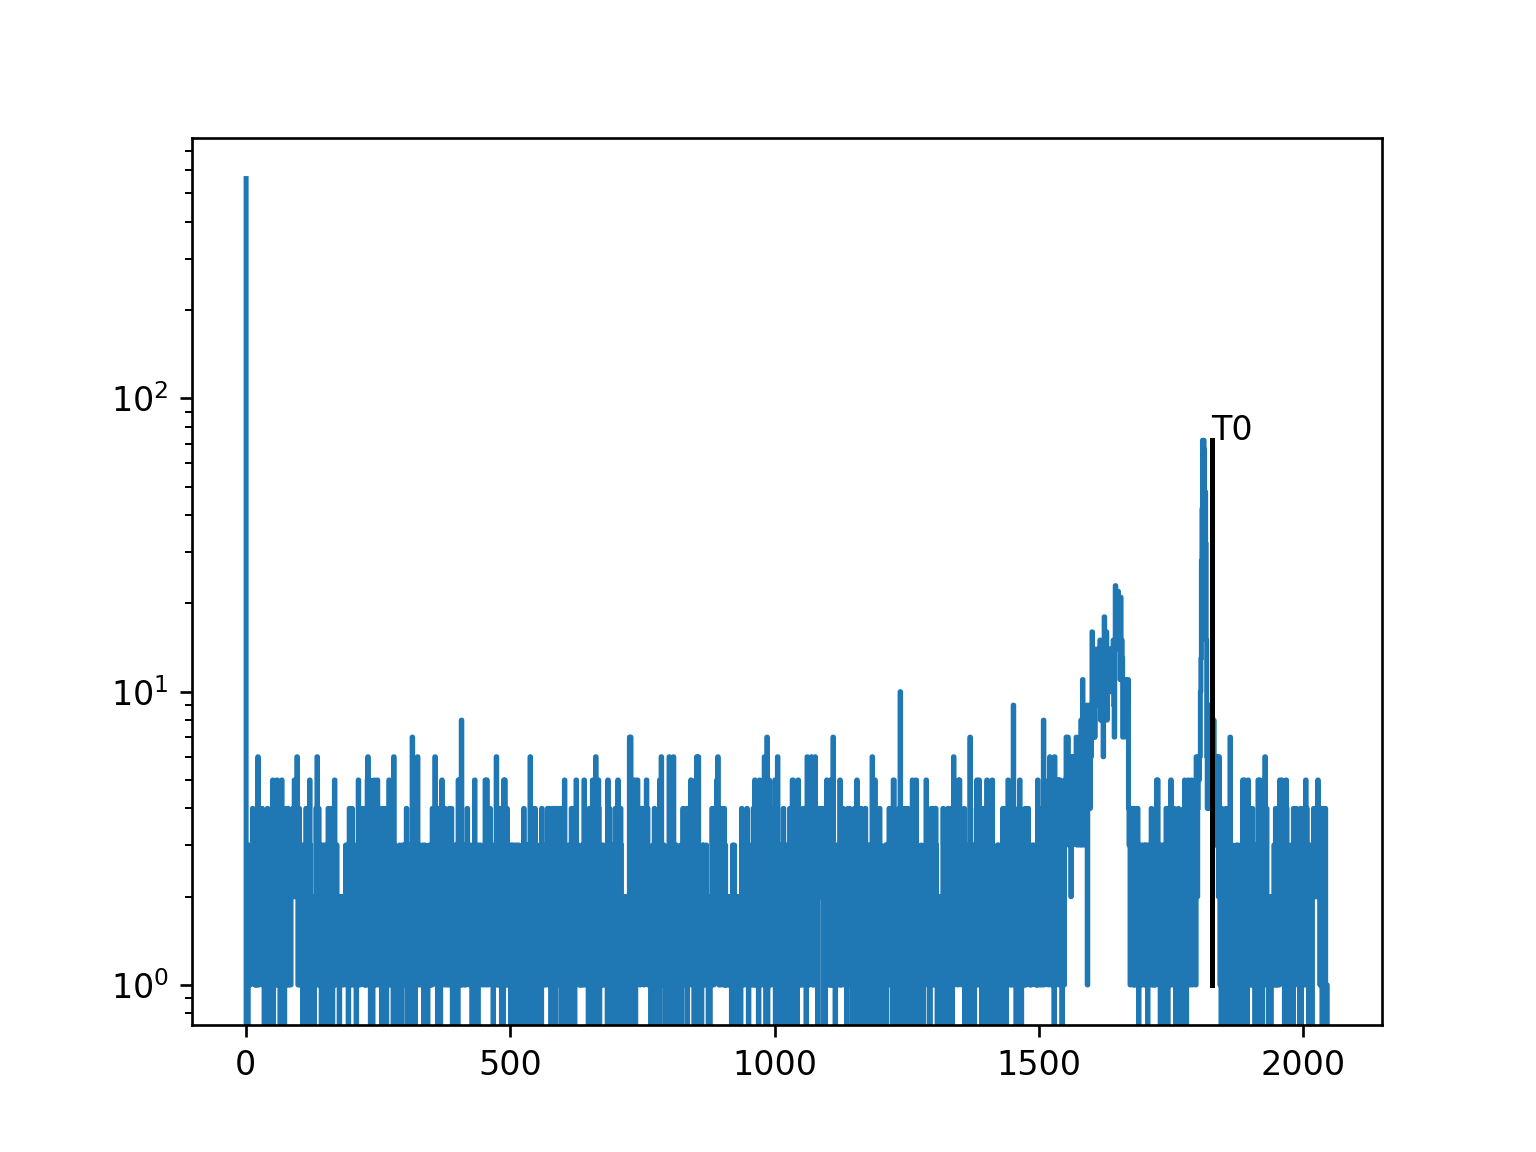

In [6]:
fig, axes = plt.subplots()

# plot data
plt.yscale('log')
#plt.ylim(ymin=1, ymax=10e10)
axes.plot(getBinCenters(tof.bins), tof.data, label="TOF data", ls="steps")

# add text with T0 indicated
axes.text(T0, gammaflash_fit.A, "T0")
axes.plot((T0, T0), (1, gammaflash_fit.A), 'k-')


<IPython.core.display.Javascript object>


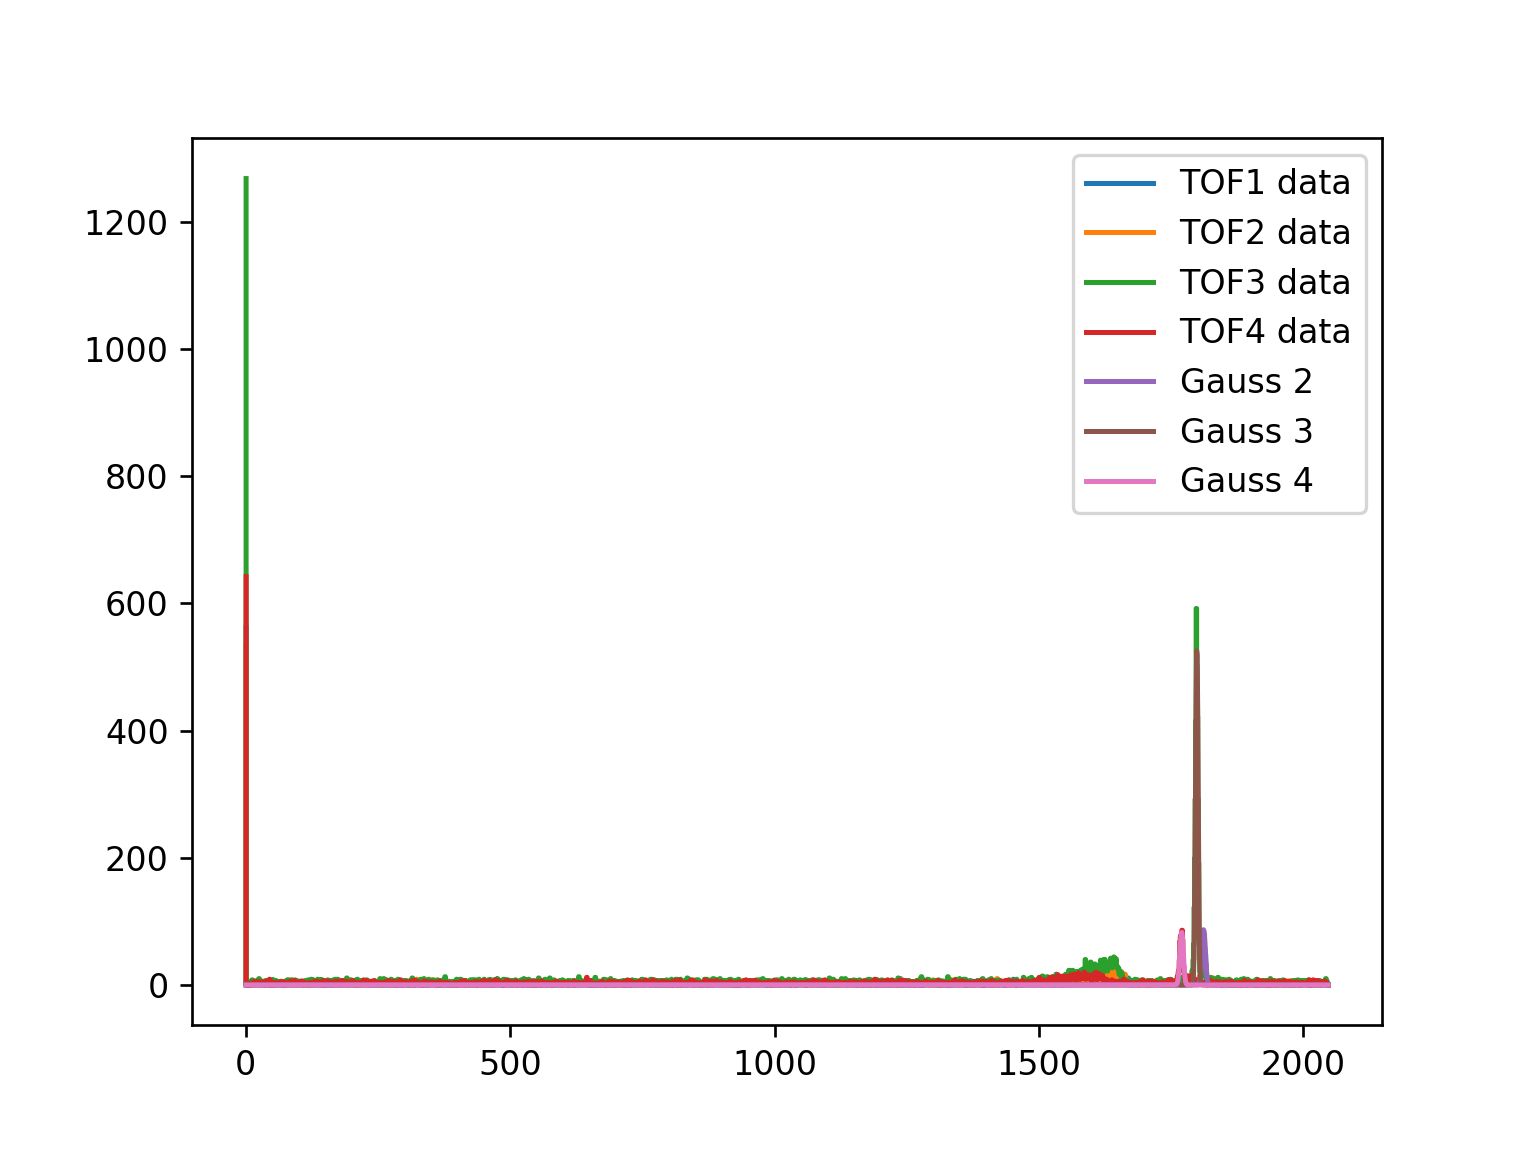

In [7]:
tof2 = histhelpers.import_hist_from_csv('hc1_5_1.csv')
tof3 = histhelpers.import_hist_from_csv('hc1_5_2.csv')
tof4 = histhelpers.import_hist_from_csv('hc1_5_3.csv')

fig, axes = plt.subplots()
axes.plot(getBinCenters(tof.bins), tof.data, label="TOF1 data", ls="steps")
axes.plot(getBinCenters(tof2.bins), tof2.data, label="TOF2 data", ls="steps")
axes.plot(getBinCenters(tof3.bins), tof3.data, label="TOF3 data", ls="steps")
axes.plot(getBinCenters(tof4.bins), tof4.data, label="TOF4 data", ls="steps")
plt.legend()

Now, let's fit those other gamma flash peaks! This time, we will give the position "by-eye" and then have the fitter do the rest:

In [8]:
g2 = fithelpers.fit_gaussian_at_pos(getBinCenters(tof2.bins), tof2.data, pos=1817)
axes.plot(getBinCenters(tof2.bins), g2.value(getBinCenters(tof2.bins)), label="Gauss 2")
g3 = fithelpers.fit_gaussian_at_pos(getBinCenters(tof3.bins), tof3.data, pos=1798)
axes.plot(getBinCenters(tof3.bins), g3.value(getBinCenters(tof3.bins)), label="Gauss 3")
g4 = fithelpers.fit_gaussian_at_pos(getBinCenters(tof4.bins), tof4.data, pos=1770)
axes.plot(getBinCenters(tof4.bins), g4.value(getBinCenters(tof4.bins)), label="Gauss 4")
plt.legend()

shifting hc1_5_1.csv by 0.6008942126170496 and rebin to match hc1_5_0.csv
shifting hc1_5_2.csv by 13.415221781896435 and rebin to match hc1_5_0.csv
shifting hc1_5_3.csv by 42.22154941099984 and rebin to match hc1_5_0.csv


<IPython.core.display.Javascript object>


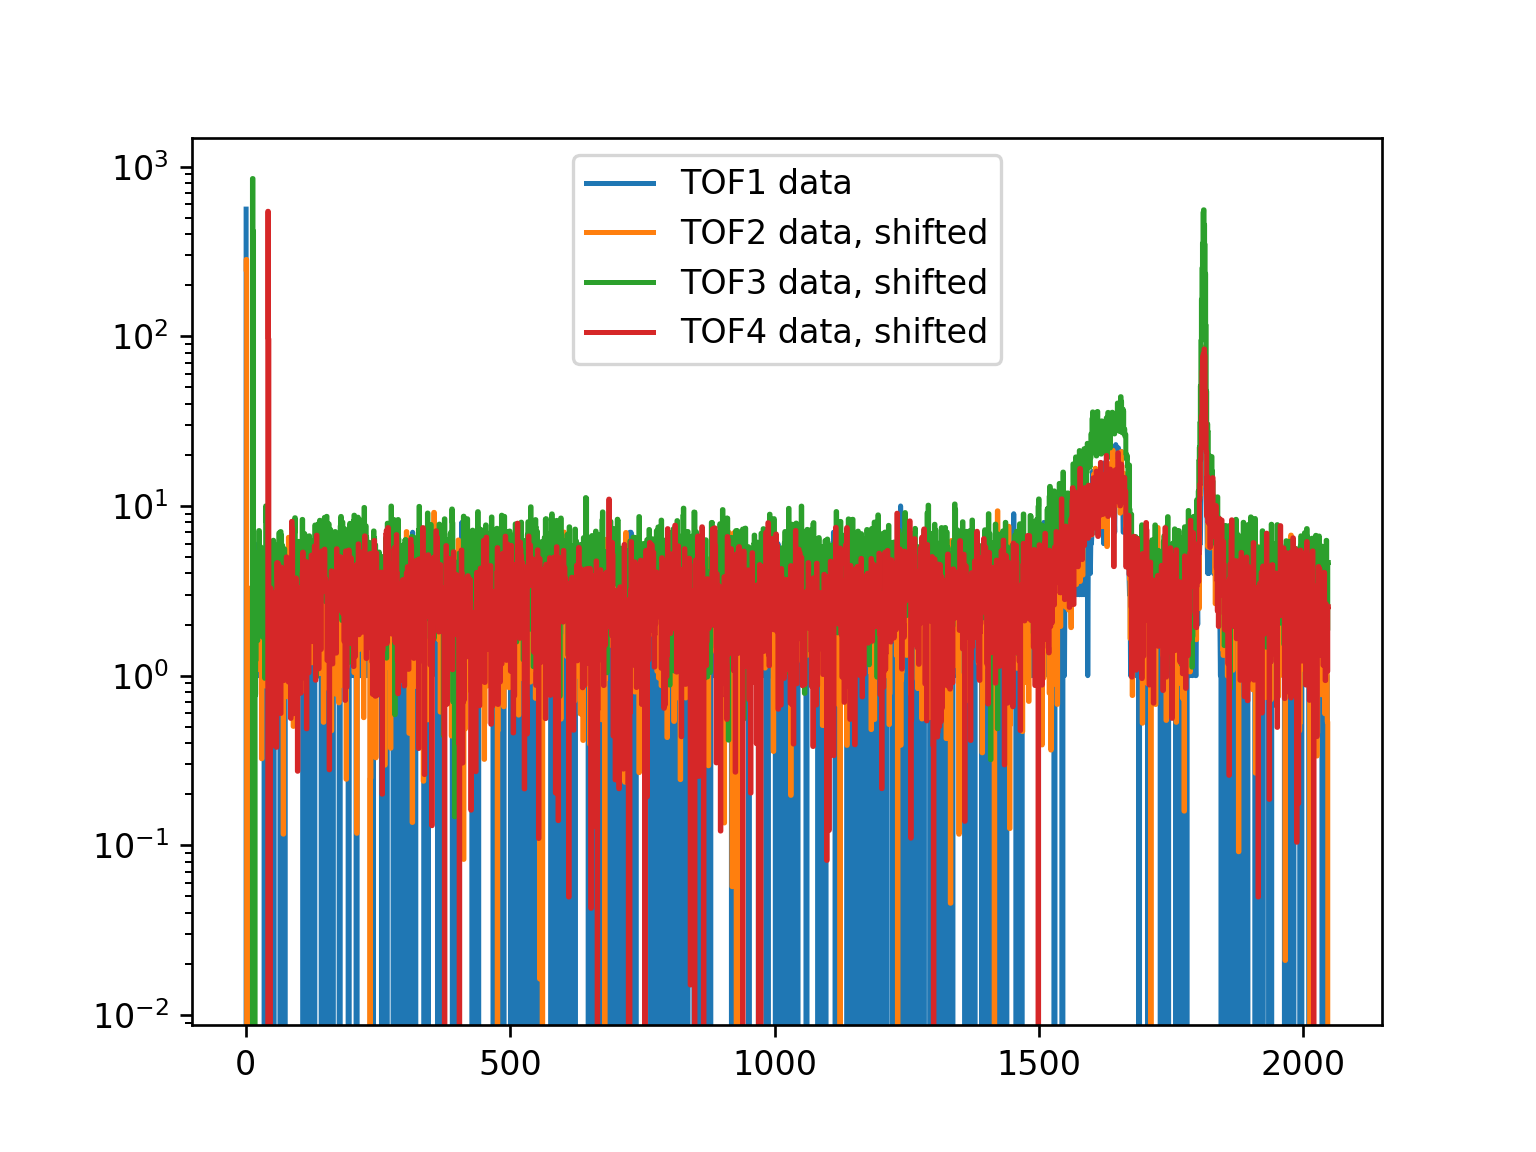

In [9]:
import rebin
import copy

def shift(spec1, spec2, amount):
    print("shifting {} by {} and rebin to match {}".format(spec2.filename, amount, spec1.filename))
    # make a copy of the spectrum to be returned later
    out = copy.deepcopy(spec2)
    # shift the bins
    out.bins += amount
    # rebin the (shifted) data to match the first spectrum
    out.data = rebin.rebin(out.bins, out.data, spec1.bins)
    # adjust the binning to match spectrum one's
    out.bins = spec1.bins
    return out

tof2_shifted = shift(tof, tof2, gammaflash_fit.mu-g2.mu)
tof3_shifted = shift(tof, tof3, gammaflash_fit.mu-g3.mu)
tof4_shifted = shift(tof, tof4, gammaflash_fit.mu-g4.mu)

fig, axes = plt.subplots()
axes.plot(getBinCenters(tof.bins), tof.data, label="TOF1 data")
axes.plot(getBinCenters(tof2_shifted.bins), tof2_shifted.data, label="TOF2 data, shifted", ls="steps")
axes.plot(getBinCenters(tof2_shifted.bins), tof3_shifted.data, label="TOF3 data, shifted", ls="steps")
axes.plot(getBinCenters(tof2_shifted.bins), tof4_shifted.data, label="TOF4 data, shifted", ls="steps")
plt.yscale('log')
plt.legend()

Now let's add the data together and plot the result:

<IPython.core.display.Javascript object>


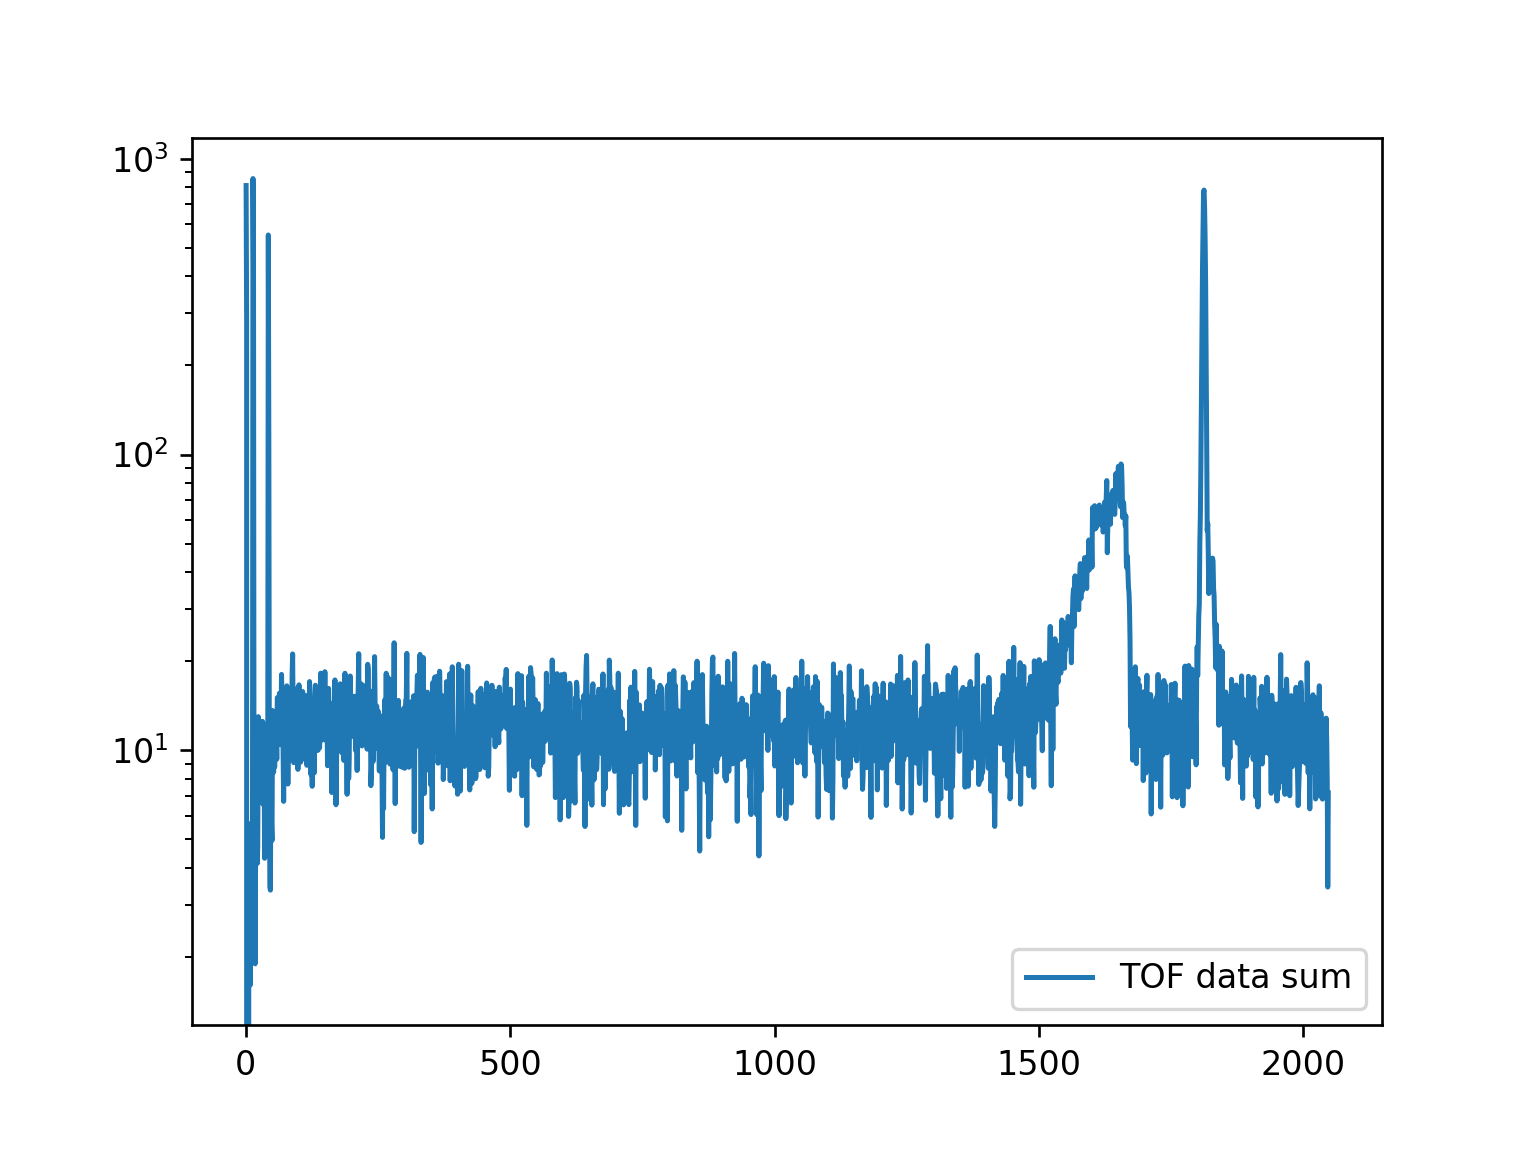

In [10]:
tof_sum = copy.deepcopy(tof)
tof_sum.data = tof.data + tof2_shifted.data + tof3_shifted.data + tof4_shifted.data
fig, axes = plt.subplots()
axes.plot(getBinCenters(tof_sum.bins), tof_sum.data, label="TOF data sum")
plt.yscale('log')
plt.legend()

For clarity, let's put the axis into the correct time binning, invert it and shift the zero position to T0

<IPython.core.display.Javascript object>


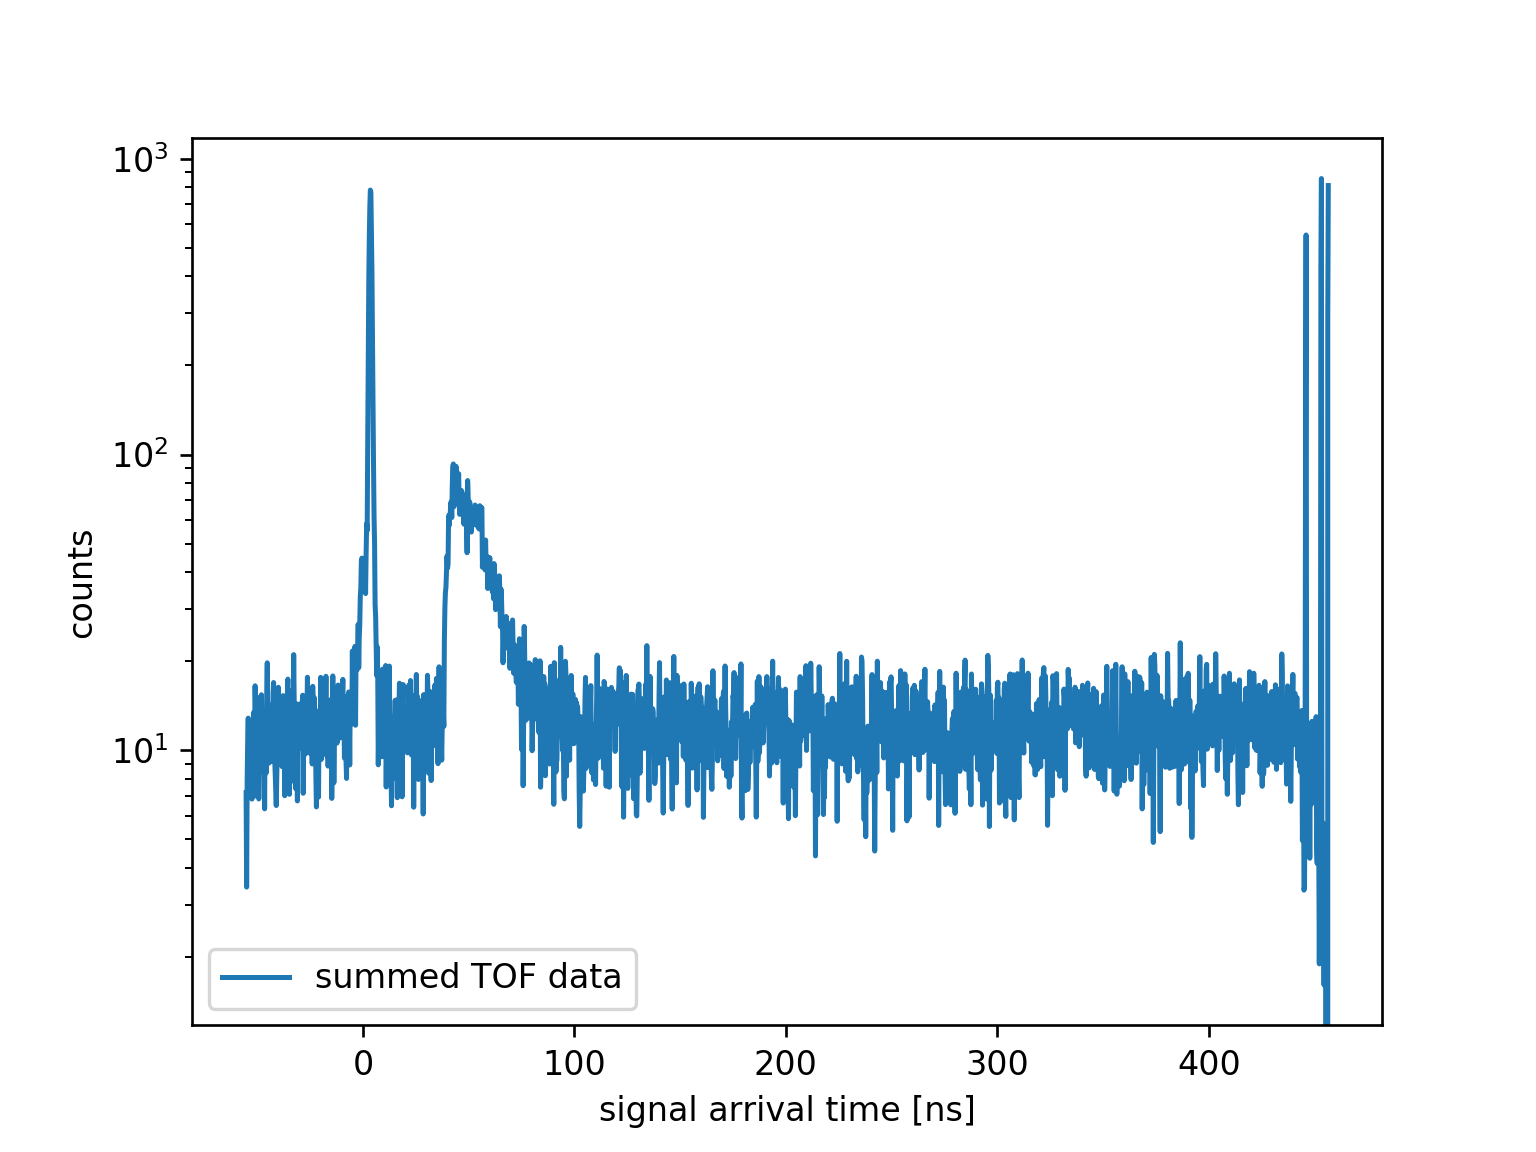

In [11]:
# copy spectrum into new data structure (before messing with it)
tof_in_ns = copy.deepcopy(tof_sum)
# now align the axis so that 0 =^= T0 and convert TDC channel to time [ns]
tof_in_ns.bins = ((-1) * tof.bins + T0) * seconds_per_TDC_channel
tof_in_ns.bins *= 1e9 # convert s in ns
# plot the result
fig, axes = plt.subplots()
axes.plot(getBinCenters(tof_in_ns.bins), tof_in_ns.data, label="summed TOF data")
plt.xlabel('signal arrival time [ns]')
plt.ylabel('counts')
plt.yscale('log')
plt.legend()

<IPython.core.display.Javascript object>


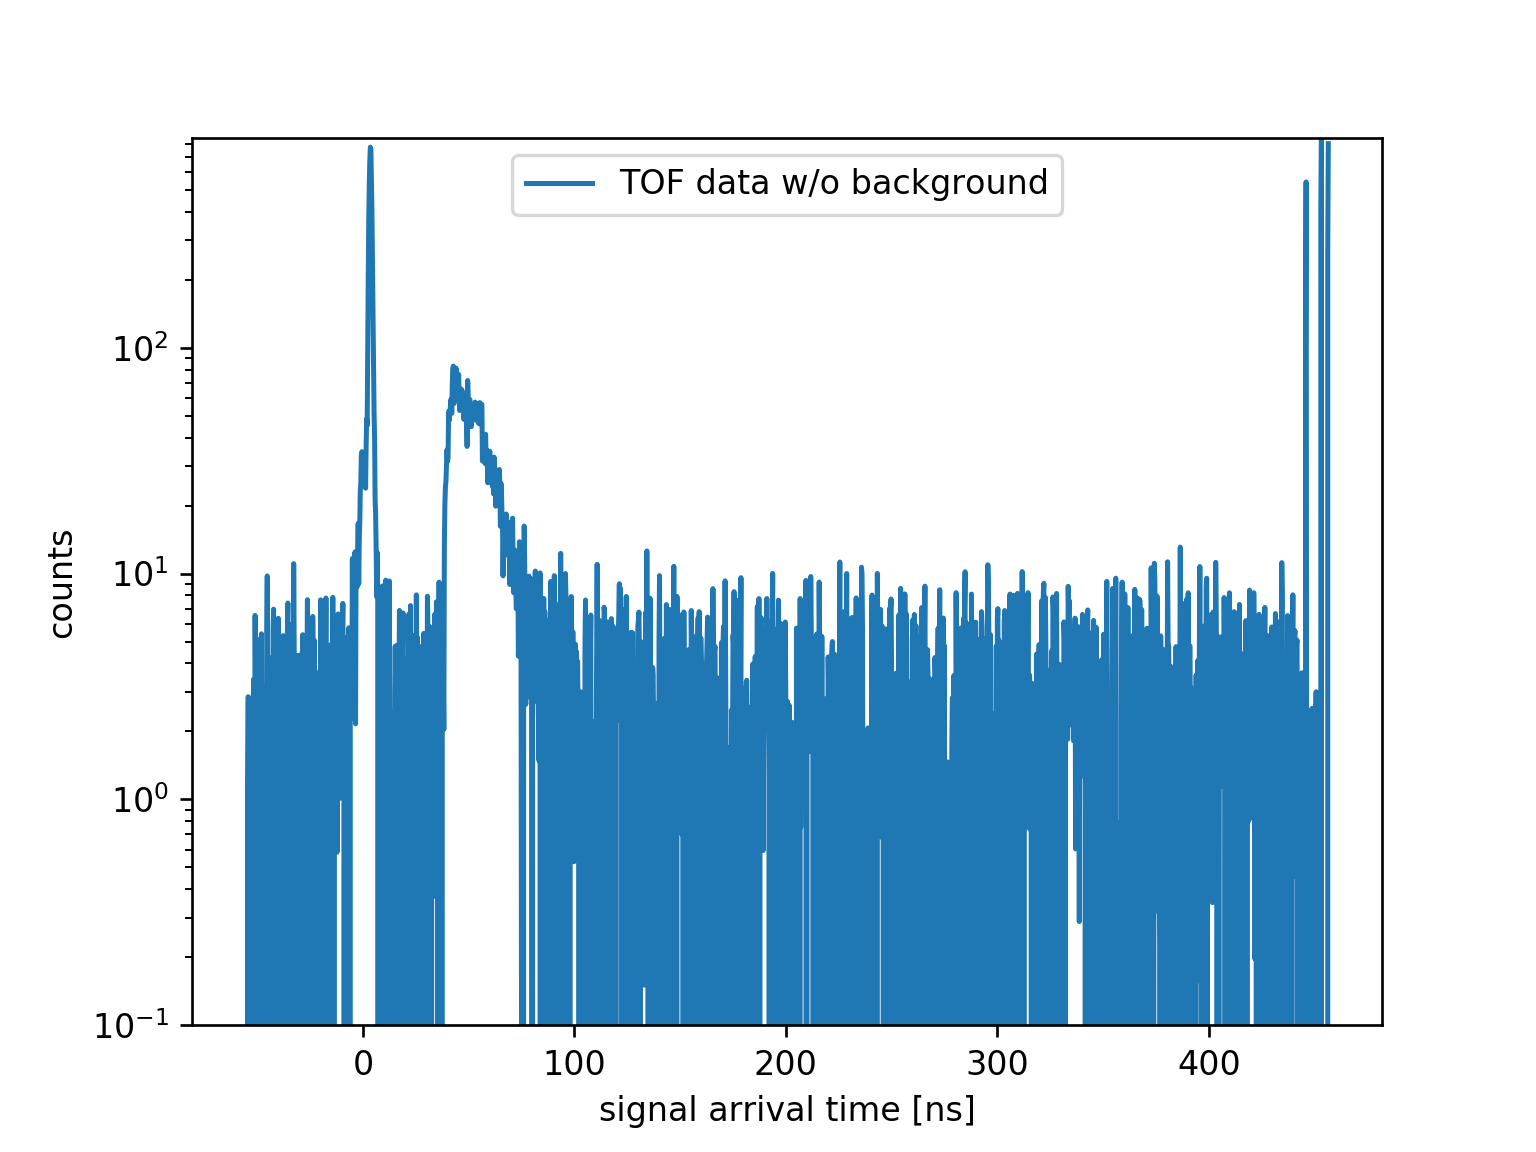

In [12]:
tof_wo_bckgrd = copy.deepcopy(tof_in_ns)
# subtract background
tof_wo_bckgrd.data -= 10
# plot the result
fig, axes = plt.subplots()
plt.ylim(0.1,max(tof_wo_bckgrd.data))
axes.plot(getBinCenters(tof_wo_bckgrd.bins), tof_wo_bckgrd.data, label="TOF data w/o background")
plt.xlabel('signal arrival time [ns]')
plt.ylabel('counts')
plt.yscale('log')
plt.legend()

<IPython.core.display.Javascript object>


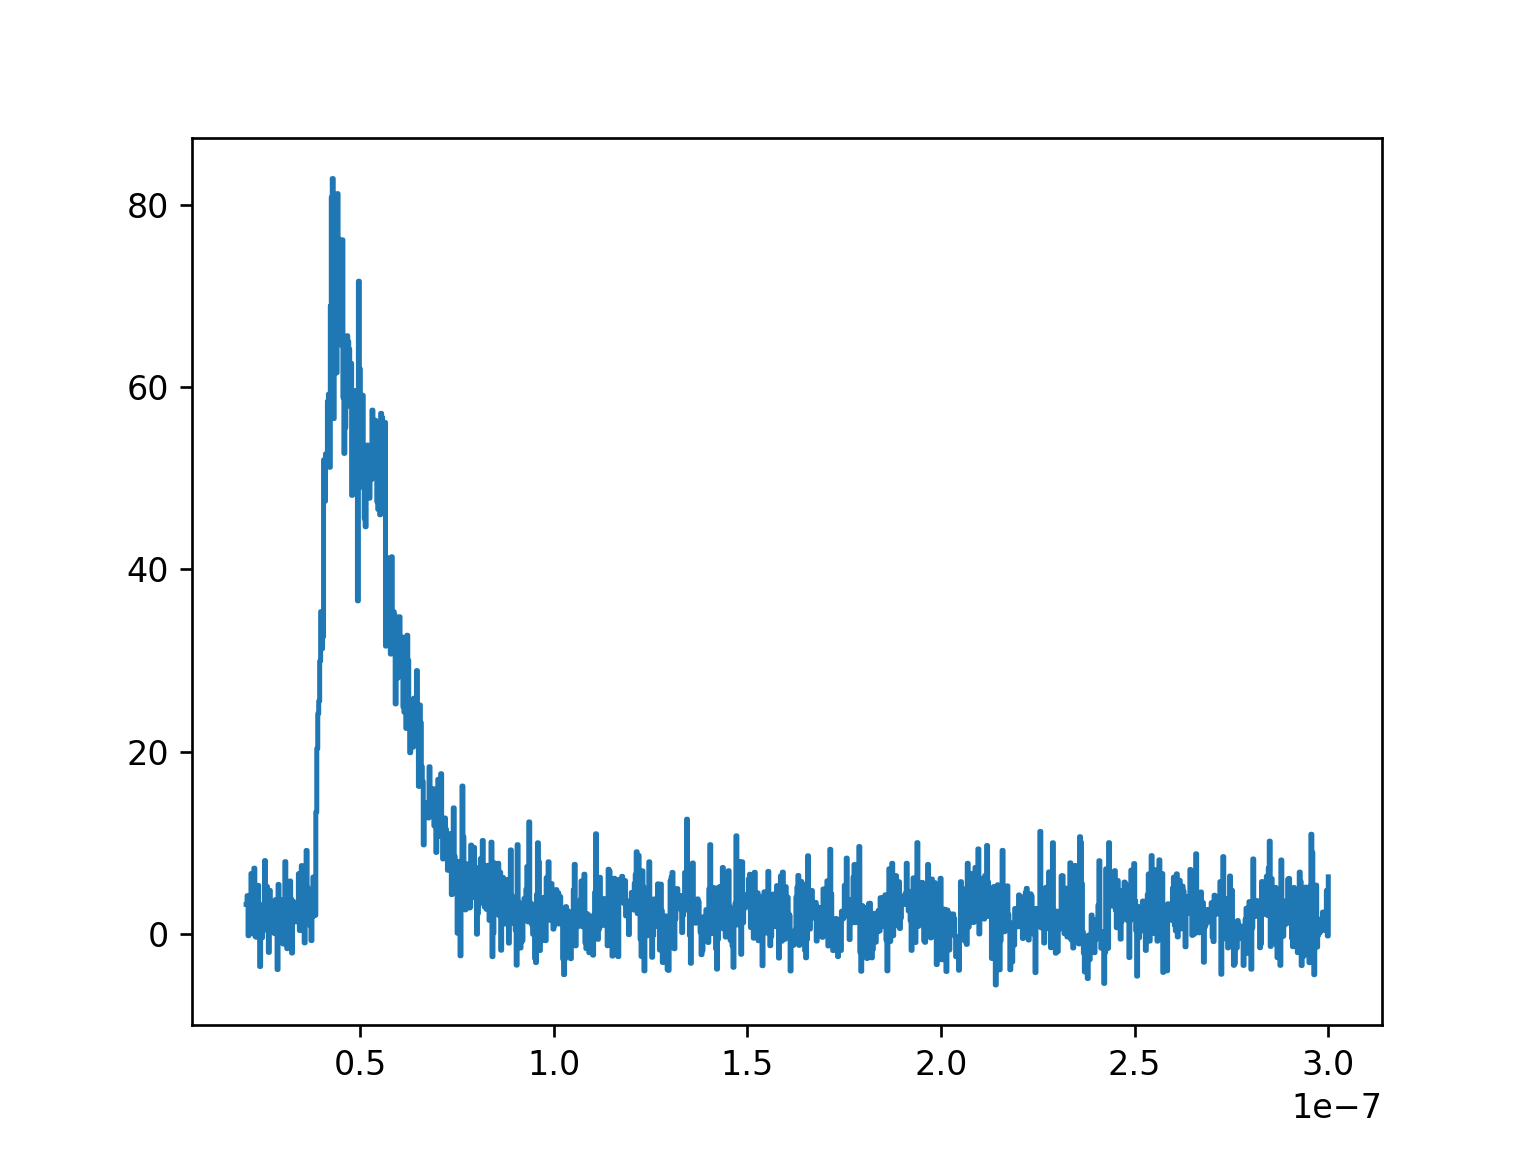

<IPython.core.display.Javascript object>


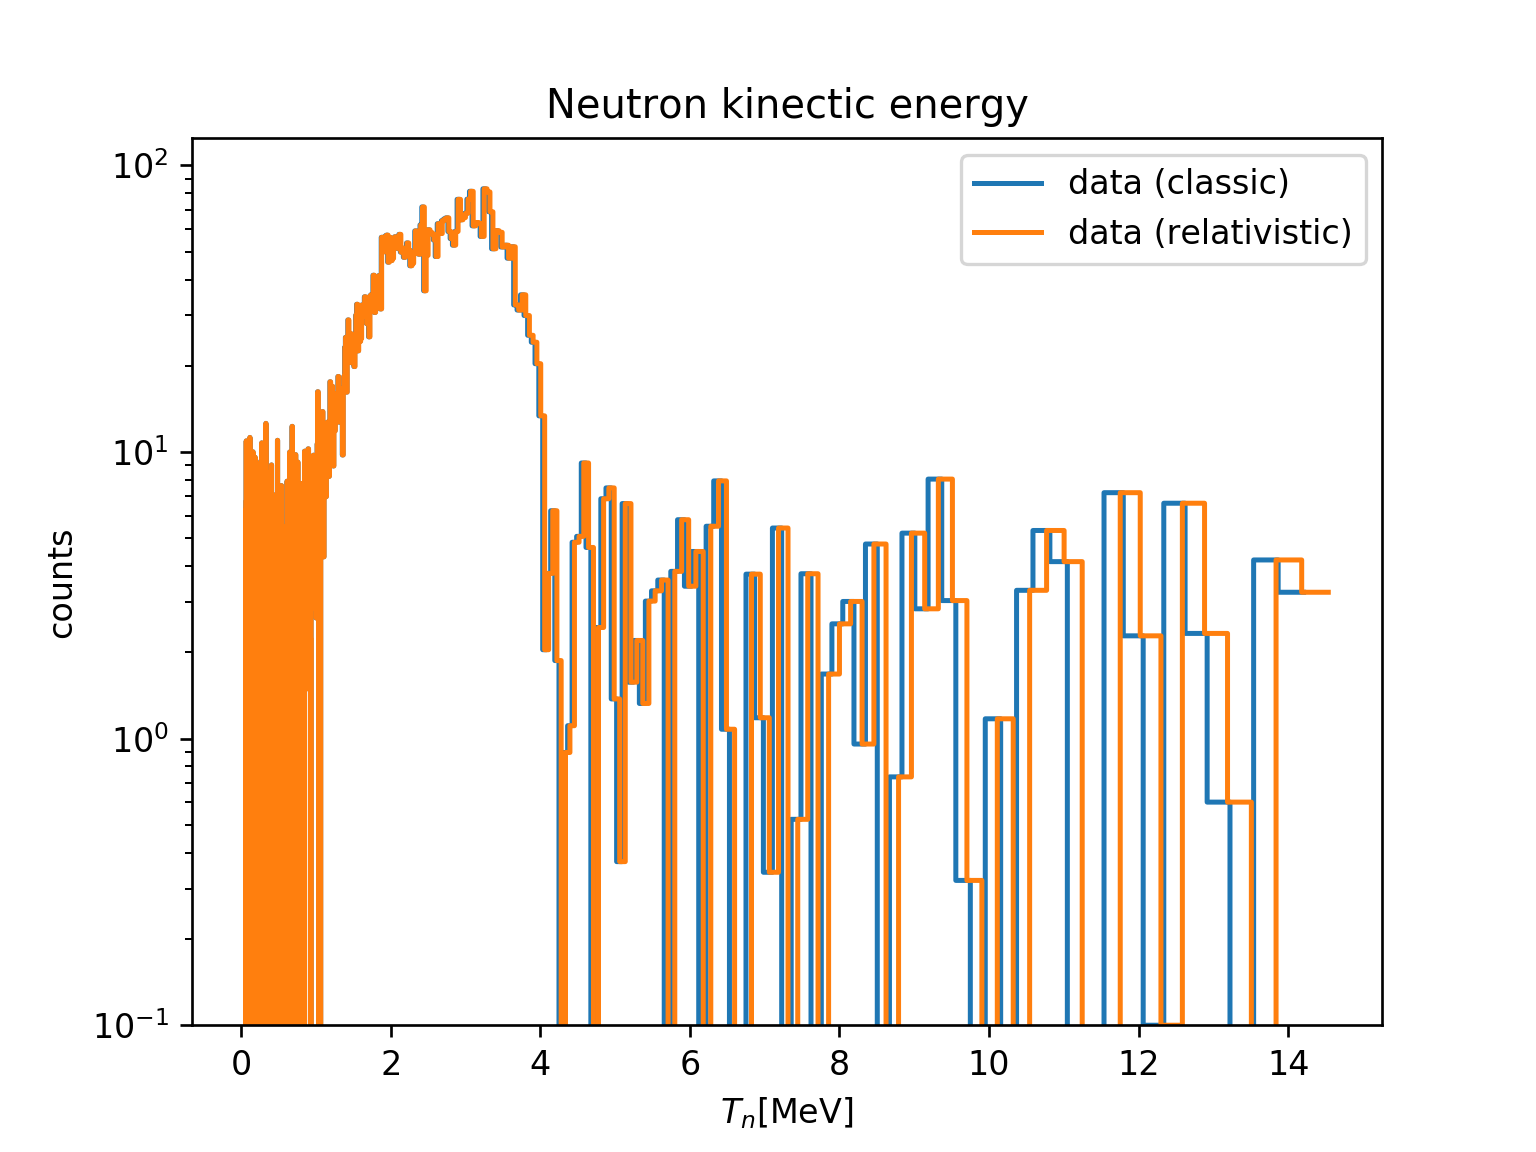

In [13]:
## constants:
M_n = 939.57  ## mass of n in MeV/c**2

Tn = copy.deepcopy(tof_wo_bckgrd)

## remove some of the data that would mess up our calculation:
## - find all bins with x > 0, remember last index
##   (why last and not first: the order in memory stays 
##    but we flipped the axis when we multiplied with -1 above)
idx_low = np.where(Tn.bins>20)[0][-1]
idx_high = np.where(Tn.bins>300)[0][-1]
## strip all other bins to remove those with x < 0
Tn.bins = Tn.bins[idx_high:idx_low]
Tn.data = Tn.data[idx_high:idx_low-1] # mind the offset, len(bins) = len(data)+1 !
Tn.bins *= 1e-9 # convert to seconds

fig, axes = plt.subplots()
axes.plot(getBinCenters(Tn.bins), Tn.data, label="data (cut)", linestyle="steps")

## non-relativistic/classic approach:
Tn_cls = copy.deepcopy(Tn)
Tn_cls.bins = 0.5 * (M_n / pow (speed_of_light, 2)) * ( pow(distance, 2) / pow(Tn_cls.bins, 2) )
## relativistic approach: B. Nilsson PhD thesis, LU, 2003, equation 2.7
Tn_rlv = copy.deepcopy(Tn)
beta = 1. / ( 1. + ((Tn_rlv.bins - distance / speed_of_light) * speed_of_light / distance))
Tn_rlv.bins = M_n * ( ( 1. / np.sqrt(1. - pow(beta, 2))) - 1. )

# plot the result
fig, axes = plt.subplots()
axes.plot(getBinCenters(Tn_cls.bins), Tn_cls.data, label="data (classic)", linestyle="steps")
axes.plot(getBinCenters(Tn_rlv.bins), Tn_rlv.data, label="data (relativistic)", linestyle="steps")

plt.xlabel(r'$T_n \mathrm{[MeV]}$')
plt.ylabel('counts')
plt.yscale('log')
plt.ylim(ymin=0.1)
plt.title("Neutron kinectic energy")
plt.legend()

This is a variation, and part of a FYSC12 excercise: the students should determine T0 from the data, but the spectrum is "preprocessed" to look right in time and shifted by a known number of channels:

<IPython.core.display.Javascript object>


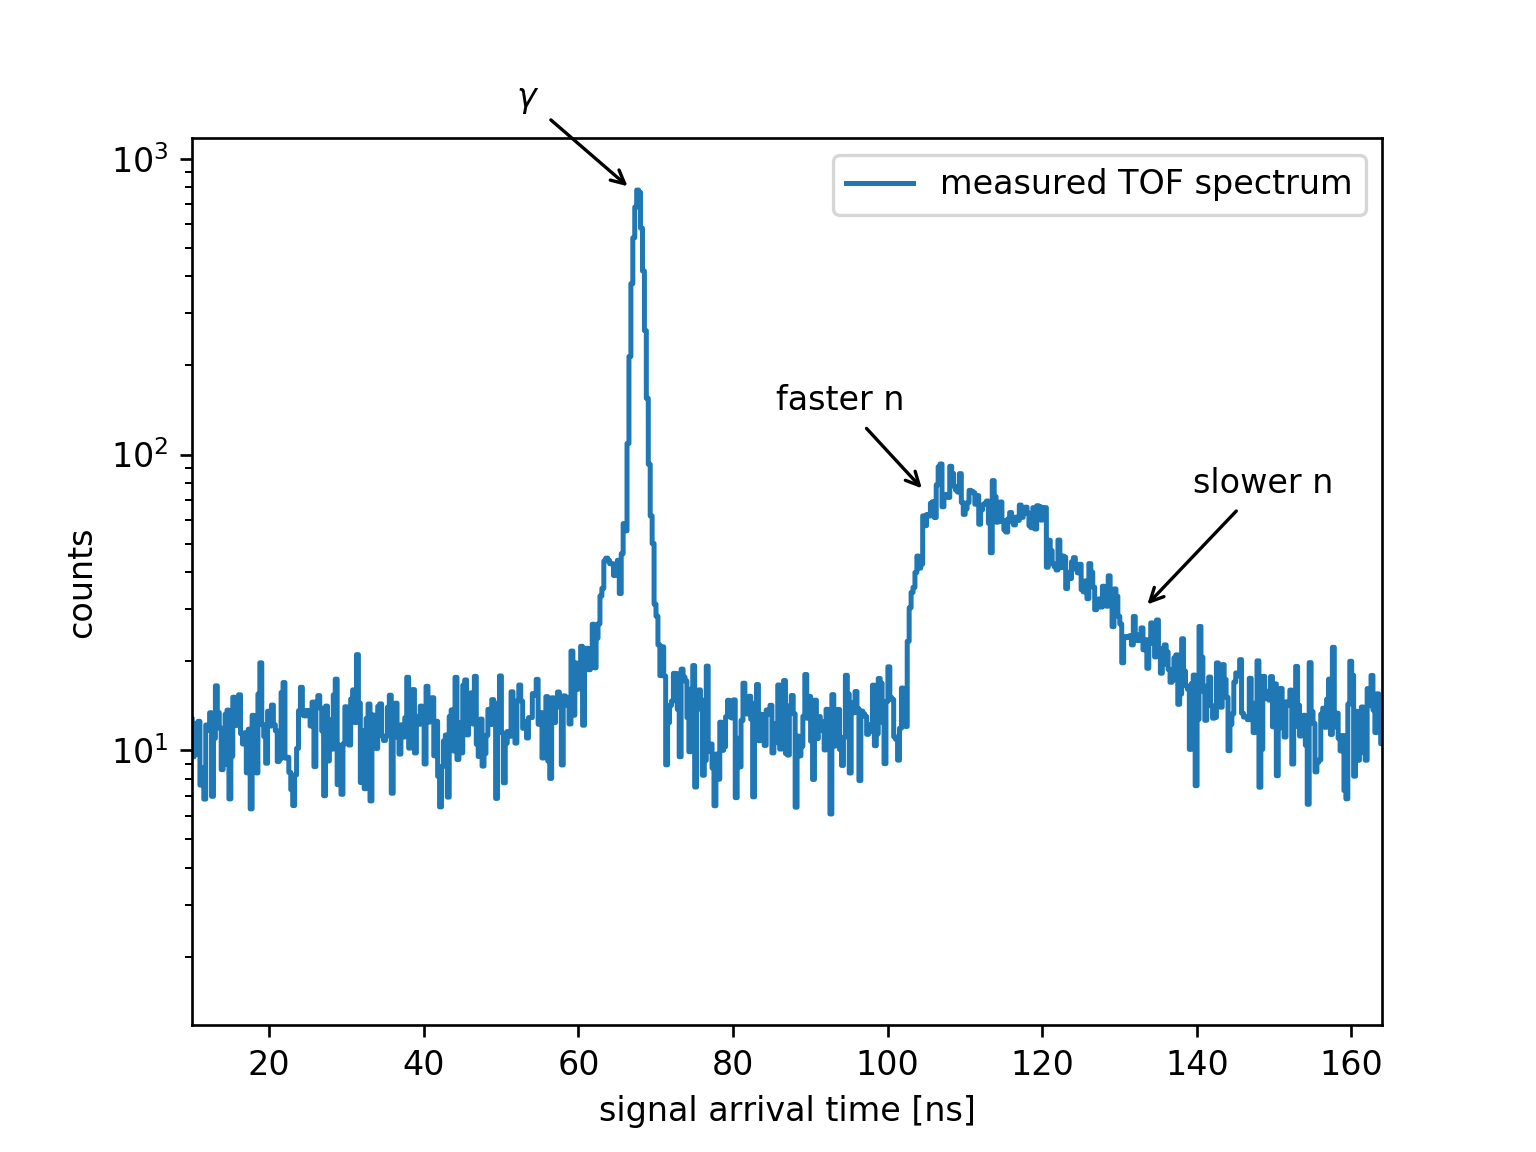

In [14]:
# copy spectrum into new data structure (before messing with it)
import copy
tof_in_ch = copy.deepcopy(tof_sum)
# now align the axis so that 0 =^= T0 and convert to ns
tof_in_ch.bins = ((-1) * tof.bins + T0)* seconds_per_TDC_channel * 1e
# now shift the spectrum for the purpose of the exercise
shift = 64
tof_in_ch.bins += shift
# plot result
fig, axes = plt.subplots()
axes.plot(getBinCenters(tof_in_ch.bins), tof_in_ch.data, label="measured TOF spectrum", ls="steps")
plt.xlabel('signal arrival time [ns]')
plt.ylabel('counts')
plt.yscale('log')
plt.xlim(10, 100+shift)
axes.annotate(r'$\gamma$',
            xy=(67, 780), xycoords='data',
            xytext=(-35, 25), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"))             
axes.annotate('slower n',
            xy=(133, 30), xycoords='data',
            xytext=(15, 35), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"))             
axes.annotate('faster n',
            xy=(105, 74), xycoords='data',
            xytext=(-45, 25), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"))             
plt.legend()